## E3FP: Extended 3-Dimensional FingerPrint

ABSTRACT: Statistical and machine learning approaches
predict drug-to-target relationships from 2D small-molecule
topology patterns. One might expect 3D information to
improve these calculations. Here we apply the logic of the
extended connectivity fingerprint (ECFP) to develop a rapid,
alignment-invariant 3D representation of molecular conformers, the extended three-dimensional fingerprint (E3FP).
By integrating E3FP with the similarity ensemble approach
(SEA), we achieve higher precision-recall performance relative
to SEA with ECFP on ChEMBL20 and equivalent receiver
operating characteristic performance. We identify classes of
molecules for which E3FP is a better predictor of similarity in
bioactivity than is ECFP. Finally, we report novel drug-to-target
binding predictions inaccessible by 2D fingerprints and confirm
three of them experimentally with ligand efficiencies from 0.442−0.637 kcal/mol/heavy atom.

Link to paper: https://pubs.acs.org/doi/pdf/10.1021/acs.jmedchem.7b00696

Credit: https://github.com/keiserlab/e3fp


In [ ]:
# Install dependencies / requirements
!pip install futures mpi4py h5py standardiser e3fp

### Configuration

E3FP configurational parameters are stored in the widely used INI file format. These may be passed to Command Line Interface programs or parsed to Python dicts for Pipeline Methods or other lower-level functions.

#### Loading Default Parameters

The below example shows all default parameters, accessed via the <code>e3fp.config module</code>.

```
# defaults.cfg
[preprocessing]
standardise = False
protonate = False

[conformer_generation]
num_conf = -1
first = -1
pool_multiplier = 1
rmsd_cutoff = 0.5
max_energy_diff = None
forcefield = uff
out_dir = conformers
compress = 2
seed = -1

; Optimized parameters used in
; Axen et al. 2017
[fingerprinting]
bits = 1024
level = 5
first = 3
radius_multiplier = 1.718
stereo = True
counts = False
include_disconnected = True
rdkit_invariants = False
remove_duplicate_substructs = True
exclude_floating = True
```

<code>configparser</code> is used internally to parse and store these config parameters.

In [9]:
from e3fp.config.params import default_params

default_params
print(default_params.sections())
default_params.items('fingerprinting')

['preprocessing', 'conformer_generation', 'fingerprinting']


[('bits', '1024'),
 ('level', '5'),
 ('first', '3'),
 ('radius_multiplier', '1.718'),
 ('stereo', 'True'),
 ('counts', 'False'),
 ('include_disconnected', 'True'),
 ('rdkit_invariants', 'False'),
 ('remove_duplicate_substructs', 'True'),
 ('exclude_floating', 'True')]

### Parsing User-Provided Parameters

A user may provide a custom config file.

```
# new_params.cfg
[conformer_generation]
first = 10

[fingerprinting]
bits = 4096
first = 10
```

In [10]:
!echo -e "[conformer_generation]\n first = 10\n \n [fingerprinting]\n bits = 4096\n first = 10" >> new_params.cfg

In [11]:
from e3fp.config.params import read_params

config = read_params("new_params.cfg")
config.items('fingerprinting')

[('bits', '4096'), ('first', '10')]

When passing these parameters to any downstream methods, default options will be used except where these options are specified.

#### Converting Parameters to Argument Dicts

To pass the parameters to Python methods for fingerprinting and conformer generation, we need to convert them to Python dicts.

In [ ]:
# Install RDKit 
!pip install rdkit-pypi==2021.3.1.5

In [14]:
from e3fp.pipeline import params_to_dicts

confgen_params, fprint_params = params_to_dicts(config)
fprint_params

{'bits': 4096, 'first': 10}

### Command Line Interface
Command line interfaces (CLI) are provided for the two most common tasks: conformer generation and fingerprinting. At the moment, using the CLI requires downloading the E3FP source.

In the below examples, we assume the E3FP repository is located at <code>$E3FP_REPO</code>.

#### Conformer Generation CLI

To see all available options, run

```
$ python $E3FP_REPO/e3fp/conformer/generate.py --help
usage: Generate conformers from mol2 or SMILES [-h] [-m MOL2 [MOL2 ...]]
                                               [-s SMILES [SMILES ...]]
                                               [--standardise STANDARDISE]
                                               [-n NUM_CONF] [--first FIRST]
                                               [--pool_multiplier POOL_MULTIPLIER]
                                               [-r RMSD_CUTOFF]
                                               [-e MAX_ENERGY_DIFF]
                                               [-f {uff,mmff94,mmff94s}]
                                               [--seed SEED] [-o OUT_DIR]
                                               [-C {None,0,2,1}] [-O]
                                               [--values_file VALUES_FILE]
                                               [--prioritize]
                                               [--params PARAMS] [-l LOG]
                                               [-p NUM_PROC]
                                               [--parallel_mode {mpi,processes,threads,serial}]
                                               [-v]

optional arguments:
  -h, --help            show this help message and exit
  -m MOL2 [MOL2 ...], --mol2 MOL2 [MOL2 ...]
                        Path to mol2 file(s), each with one molecule.
                        (default: None)
  -s SMILES [SMILES ...], --smiles SMILES [SMILES ...]
                        Path to file(s) with SMILES and name. (space-
                        separated) (default: None)
  --standardise STANDARDISE
                        Clean molecules before generating conformers by
                        standardisation. (default: False)
  -n NUM_CONF, --num_conf NUM_CONF
                        Set single number of conformers to use. -1 results in
                        auto choosing. (default: -1)
  --first FIRST         Set maximum number of first conformers to accept.
                        Conformer generation is unaffected, except it may
                        terminate early when this number of conformers is
                        reached. (default: -1)
  --pool_multiplier POOL_MULTIPLIER
                        Factor to multiply `num_conf` by to generate
                        conformers. Results are then pruned to `num_conf`.
                        (default: 1)
  -r RMSD_CUTOFF, --rmsd_cutoff RMSD_CUTOFF
                        Choose RMSD cutoff between conformers (default: 0.5)
  -e MAX_ENERGY_DIFF, --max_energy_diff MAX_ENERGY_DIFF
                        Maximum energy difference between lowest energy
                        conformer and any accepted conformer. (default: None)
  -f {uff,mmff94,mmff94s}, --forcefield {uff,mmff94,mmff94s}
                        Choose forcefield for minimization. (default: uff)
  --seed SEED           Random seed for conformer generation. (default: -1)
  -o OUT_DIR, --out_dir OUT_DIR
                        Directory to save conformers. (default: conformers)
  -C {None,0,2,1}, --compress {None,0,2,1}
                        Compression to use for SDF files. None and 0 default
                        to uncompressed ".sdf". 1 and 2 result in gzipped and
                        bzipped SDF files, respectively. (default: 2)
  -O, --overwrite       Overwrite existing conformer files. (default: False)
  --values_file VALUES_FILE
                        Save RMSDs and energies to specified hdf5 file.
                        (default: None)
  --prioritize          Prioritize likely fast molecules first. (default:
                        False)
  --params PARAMS       INI formatted file with parameters. If provided, all
                        parameters controlling conformer generation are
                        ignored. (default: None)
  -l LOG, --log LOG     Generate logfile. (default: None)
  -p NUM_PROC, --num_proc NUM_PROC
                        Set number of processors to use. (default: None)
  --parallel_mode {mpi,processes,threads,serial}
                        Set number of processors to use. (default: None)
  -v, --verbose         Run with extra verbosity. (default: False)
```

We will generate conformers for the molecule whose SMILES string is defined in <code>caffeine.smi</code>.

```
# caffeine.smi
CN1C=NC2=C1C(=O)N(C(=O)N2C)C caffeine
```

The below example generates at most 3 conformers for this molecule.

```
$ python $E3FP_REPO/e3fp/conformer/generate.py -s caffeine.smi --num_conf 3 -o ./
2017-07-17 00:11:05,743|WARNING|Only 1 processes available. 'mpi' mode not available.
2017-07-17 00:11:05,748|INFO|num_proc is not specified. 'processes' mode will use all 8 processes
2017-07-17 00:11:05,748|INFO|Parallelizer initialized with mode 'processes' and 8 processors.
2017-07-17 00:11:05,748|INFO|Input type: Detected SMILES file(s)
2017-07-17 00:11:05,748|INFO|Input file number: 1
2017-07-17 00:11:05,748|INFO|Parallel Type: processes
2017-07-17 00:11:05,748|INFO|Out Directory: ./
2017-07-17 00:11:05,749|INFO|Overwrite Existing Files: False
2017-07-17 00:11:05,749|INFO|Target Conformer Number: 3
2017-07-17 00:11:05,749|INFO|First Conformers Number: all
2017-07-17 00:11:05,749|INFO|Pool Multiplier: 1
2017-07-17 00:11:05,749|INFO|RMSD Cutoff: 0.5
2017-07-17 00:11:05,749|INFO|Maximum Energy Difference: None
2017-07-17 00:11:05,749|INFO|Forcefield: UFF
2017-07-17 00:11:05,749|INFO|Starting.
2017-07-17 00:11:05,779|INFO|Generating conformers for caffeine.
2017-07-17 00:11:05,823|INFO|Generated 1 conformers for caffeine.
2017-07-17 00:11:05,829|INFO|Saved conformers for caffeine to ./caffeine.sdf.bz2.
```

The result is a multi-conformer SDF file called <code>caffeine.sdf.bz2</code> in the current directory.

#### Fingerprinting CLI

```
$ python $E3FP_REPO/e3fp/fingerprint/generate.py --help
usage: Generate E3FP fingerprints from SDF files. [-h] [-b BITS]
                                                  [--first FIRST] [-m LEVEL]
                                                  [-r RADIUS_MULTIPLIER]
                                                  [--stereo STEREO]
                                                  [--counts COUNTS]
                                                  [--params PARAMS]
                                                  [-o OUT_DIR_BASE]
                                                  [--out_ext {.fp.pkl,.fp.gz,.fp.bz2}]
                                                  [-d DB_FILE] [--all_iters]
                                                  [-O] [-l LOG] [-p NUM_PROC]
                                                  [--parallel_mode {mpi,processes,threads,serial}]
                                                  [-v]
                                                  sdf_files [sdf_files ...]

positional arguments:
  sdf_files             Path to SDF file(s), each with one molecule and
                        multiple conformers.

optional arguments:
  -h, --help            show this help message and exit
  -b BITS, --bits BITS  Set number of bits for final folded fingerprint. If -1
                        or None, unfolded (2^32-bit) fingerprints are
                        generated. (default: 4294967296)
  --first FIRST         Set maximum number of first conformers for which to
                        generate fingerprints. (default: 3)
  -m LEVEL, --level LEVEL, --max_iterations LEVEL
                        Maximum number of iterations for fingerprint
                        generation. If -1, fingerprinting is run until
                        termination, and `all_iters` is set to False.
                        (default: 5)
  -r RADIUS_MULTIPLIER, --radius_multiplier RADIUS_MULTIPLIER, --shell_radius RADIUS_MULTIPLIER
                        Distance to increment shell radius at around each
                        atom, starting at 0.0. (default: 1.718)
  --stereo STEREO       Differentiate by stereochemistry. (default: True)
  --counts COUNTS       Store counts-based E3FC instead of default bit-based.
                        (default: False)
  --params PARAMS       INI formatted file with parameters. If provided, all
                        parameters controlling conformer generation are
                        ignored. (default: None)
  -o OUT_DIR_BASE, --out_dir_base OUT_DIR_BASE
                        Basename for output directory to save fingerprints.
                        Iteration number is appended to basename. (default:
                        None)
  --out_ext {.fp.pkl,.fp.gz,.fp.bz2}
                        Extension for fingerprint pickles. (default: .fp.bz2)
  -d DB_FILE, --db_file DB_FILE
                        Output file containing FingerprintDatabase object
                        (default: fingerprints.fpz)
  --all_iters           Save fingerprints from all iterations to file(s).
                        (default: False)
  -O, --overwrite       Overwrite existing file(s). (default: False)
  -l LOG, --log LOG     Log filename. (default: None)
  -p NUM_PROC, --num_proc NUM_PROC
                        Set number of processors to use. (default: None)
  --parallel_mode {mpi,processes,threads,serial}
                        Set parallelization mode to use. (default: None)
  -v, --verbose         Run with extra verbosity. (default: False)
```

To continue the above example, we will fingerprint our caffeine conformers.

```
$ python $E3FP_REPO/e3fp/fingerprint/generate.py caffeine.sdf.bz2 --bits 1024
2017-07-17 00:12:33,797|WARNING|Only 1 processes available. 'mpi' mode not available.
2017-07-17 00:12:33,801|INFO|num_proc is not specified. 'processes' mode will use all 8 processes
2017-07-17 00:12:33,801|INFO|Parallelizer initialized with mode 'processes' and 8 processors.
2017-07-17 00:12:33,801|INFO|Initializing E3FP generation.
2017-07-17 00:12:33,801|INFO|Getting SDF files
2017-07-17 00:12:33,801|INFO|SDF File Number: 1
2017-07-17 00:12:33,802|INFO|Database File: fingerprints.fpz
2017-07-17 00:12:33,802|INFO|Max First Conformers: 3
2017-07-17 00:12:33,802|INFO|Bits: 1024
2017-07-17 00:12:33,802|INFO|Level/Max Iterations: 5
2017-07-17 00:12:33,802|INFO|Shell Radius Multiplier: 1.718
2017-07-17 00:12:33,802|INFO|Stereo Mode: True
2017-07-17 00:12:33,802|INFO|Connected-only mode: on
2017-07-17 00:12:33,802|INFO|Invariant type: Daylight
2017-07-17 00:12:33,802|INFO|Parallel Mode: processes
2017-07-17 00:12:33,802|INFO|Starting
2017-07-17 00:12:33,829|INFO|Generating fingerprints for caffeine.
2017-07-17 00:12:33,935|INFO|Generated 1 fingerprints for caffeine.
2017-07-17 00:12:34,011|INFO|Saved FingerprintDatabase with fingerprints to fingerprints.fpz
```

The result is a file <code>fingerprints.fpz</code> containing a <code>FingerprintDatabase</code>. To use such a database, consult <code>Fingerprint Storage</code>.

### Pipeline Methods

E3FP can be easily plugged into an existing pipeline using the methods in the <code>e3fp.pipeline</code> module. Each of these methods wraps functionality in other modules for generating various outputs from inputs and specified options.

First we must choose configuration options. Here we will use defaults for all but a few options.

In [26]:
fprint_params = {'bits': 4096, 'radius_multiplier': 1.5, 'rdkit_invariants': True}
confgen_params = {'max_energy_diff': 20.0, 'first': 3}
smiles = "COC(=O)C(C1CCCCN1)C2=CC=CC=C2"

#### Generating Conformers from SMILES

The following code snippet generates a multi-conformer molecule:

In [27]:
from e3fp.pipeline import confs_from_smiles

mol = confs_from_smiles(smiles, "ritalin", confgen_params=confgen_params)
mol.GetNumConformers()

2021-05-26 19:50:41,751|INFO|Generating conformers for ritalin.
2021-05-26 19:50:43,545|INFO|Generated 3 conformers for ritalin.


3

This produces the following conformers:

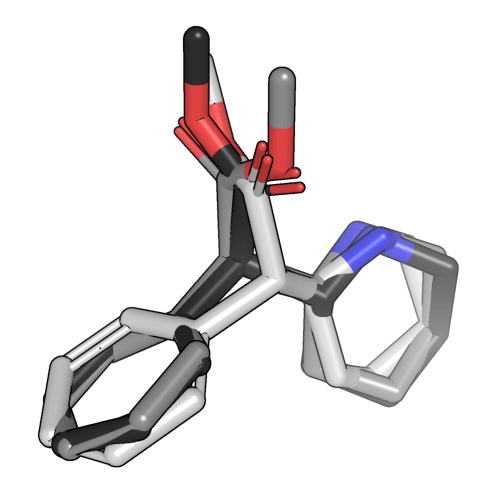

#### Generating Fingerprints from Conformers

In [29]:
from e3fp.pipeline import fprints_from_mol

fprints = fprints_from_mol(mol, fprint_params=fprint_params)
len(fprints)

fprints[0]
fprints[1]
fprints[2]

2021-05-26 19:53:44,191|INFO|Generating fingerprints for ritalin.
2021-05-26 19:53:44,446|INFO|Generated 3 fingerprints for ritalin.


Fingerprint(indices=array([188, 206, 224, 356, 401, 561, 562, 763, 914, 1095, 1346, 1414, 1426, 1513, 1527, 1528, 1738, 1802, 1910, 2287, 2521, 2700, 2714, 2793, 2874, 2978, 3089, 3148, 3421, 3465, 3693, 3752, 4053, 4059, 4084]), level=5, bits=4096, name=ritalin_2)

#### Generating Fingerprints from SMILES

In [30]:
from e3fp.pipeline import fprints_from_smiles

fprints = fprints_from_smiles(smiles, "ritalin", confgen_params=confgen_params, fprint_params=fprint_params)
fprints[0]

2021-05-26 19:54:23,950|INFO|Generating conformers for ritalin.
2021-05-26 19:54:25,729|INFO|Generated 3 conformers for ritalin.
2021-05-26 19:54:25,732|INFO|Generating fingerprints for ritalin.
2021-05-26 19:54:25,975|INFO|Generated 3 fingerprints for ritalin.


Fingerprint(indices=array([125, 188, 356, 380, 401, 556, 561, 562, 763, 914, 986, 1095, 1346, 1414, 1443, 1513, 1527, 1528, 1680, 1738, 1802, 1917, 2287, 2521, 2700, 2714, 2793, 2833, 2848, 2986, 3421, 3604, 3683, 3693, 4053]), level=5, bits=4096, name=ritalin_0)

#### Parallel Fingerprinting

The following script demonstrates use of <code>python_utilities</code> for fingerprinting all SDF files in a directory in parallel. This essentially is the same as the Fingerprinting CLI, albeit with a less convenient interface.

In [33]:
# generate caffeine.smi file
!echo -e "CN1C=NC2=C1C(=O)N(C(=O)N2C)C caffeine" >> caffeine.smi

In [34]:
from glob import glob
from python_utilities.parallel import Parallelizer
from e3fp.conformer.util import smiles_to_dict

smiles_dict = smiles_to_dict("caffeine.smi")
print(smiles_dict)
len(smiles_dict)

smiles_iter = ((smiles, name) for name, smiles in smiles_dict.items())
kwargs = {"confgen_params": confgen_params, "fprint_params": fprint_params}
parallelizer = Parallelizer(parallel_mode="processes")

fprints_list = parallelizer.run(fprints_from_smiles, smiles_iter, kwargs=kwargs) 
len(fprints_list) 

2021-05-26 20:02:36,423|INFO|num_proc is not specified. 'processes' mode will use all 4 processes
2021-05-26 20:02:36,424|INFO|Parallelizer initialized with mode 'processes' and 4 processors.


{'caffeine': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'}


2021-05-26 20:02:36,463|INFO|Generating conformers for caffeine.
2021-05-26 20:02:36,980|INFO|Generated 1 conformers for caffeine.
2021-05-26 20:02:36,982|INFO|Generating fingerprints for caffeine.
2021-05-26 20:02:37,045|INFO|Generated 1 fingerprints for caffeine.


1

For all pipeline methods, please see the <code>e3fp.pipeline</code> module API.

### Fingerprints

The simplest interface for molecular fingerprints are through three classes in <code>e3fp.fingerprint.fprint</code>:

```
Fingerprint 
    a fingerprint with "on" bits

CountFingerprint 
    a fingerprint with counts for each “on” bit

FloatFingerprint 
    a fingerprint with float values for each "on" bit, generated for example by averaging conformer fingerprints.
```

In addition to storing "on" indices and, for the latter two, corresponding values, they store fingerprint properties, such as name, level, and any arbitrary property. They also provide simple interfaces for fingerprint comparison, some basic processing, and comparison.

In the below examples, we will focus on <code>Fingerprint</code> and <code>CountFingerprint</code>. First, we execute the necessary imports.

In [35]:
from e3fp.fingerprint.fprint import Fingerprint, CountFingerprint
import numpy as np

#### Creation and Conversion

Here we create a bit-fingerprint with random "on" indices.

In [36]:
bits = 2**32
indices = np.sort(np.random.randint(0, bits, 30))
indices

array([ 302285912,  358009231,  541718221, 1069827052, 1133171616,
       1156373919, 1322902288, 1369851196, 1465197039, 1559304357,
       1722330369, 1837624616, 1878563365, 2057113679, 2078595714,
       2114197989, 2132809134, 2183455199, 2229421738, 2375632565,
       2778917144, 2825452805, 3033463891, 3042698286, 3366381098,
       3448196677, 3524561071, 3852231029, 4083199065, 4231559027])

In [37]:
fp1 = Fingerprint(indices, bits=bits, level=0)
fp1

Fingerprint(indices=array([302285912, 358009231, 541718221, 1069827052, 1133171616, 1156373919, 1322902288, 1369851196, 1465197039, 1559304357, 1722330369, 1837624616, 1878563365, 2057113679, 2078595714, 2114197989, 2132809134, 2183455199, 2229421738, 2375632565, 2778917144, 2825452805, 3033463891, 3042698286, 3366381098, 3448196677, 3524561071, 3852231029, 4083199065, 4231559027]), level=0, bits=4294967296, name=None)

This fingerprint is extremely sparse

In [39]:
fp1.bit_count

30

In [40]:
fp1.density

6.984919309616089e-09

We can therefore "fold" the fingerprint through a series of bitwise "OR" operations on halves of the sparse vector until it is of a specified length, with minimal collision of bits.

In [41]:
fp_folded = fp1.fold(1024)
fp_folded

Fingerprint(indices=array([46, 79, 83, 88, 89, 165, 175, 257, 261, 280, 296, 316, 373, 399, 415, 430, 479, 485, 495, 549, 554, 581, 642, 682, 693, 717, 784, 883, 928, 1004]), level=0, bits=1024, name=None)

In [42]:
fp_folded.bit_count
fp_folded.density

0.029296875

A <code>CountFingerprint</code> may be created by also providing a dictionary matching indices with nonzero counts to the counts.

In [43]:
indices2 = np.sort(np.random.randint(0, bits, 60))

counts = dict(zip(indices2, np.random.randint(1, 10, indices2.size)))
counts

{11572863: 1,
 74495151: 3,
 152873780: 4,
 484654139: 2,
 601051226: 3,
 710301887: 8,
 802878868: 9,
 866096726: 6,
 919624195: 7,
 955153512: 7,
 987292777: 9,
 1150872007: 7,
 1168886552: 5,
 1239561412: 7,
 1280021838: 3,
 1297373215: 7,
 1452672163: 2,
 1501029413: 2,
 1625348176: 6,
 1629764905: 1,
 1638557138: 6,
 1892417825: 6,
 1900283514: 5,
 1934997866: 6,
 2038373660: 7,
 2189939306: 3,
 2286219231: 1,
 2315073231: 8,
 2348893970: 7,
 2435556610: 3,
 2436950919: 3,
 2474241144: 1,
 2474779435: 5,
 2577785506: 7,
 2593380350: 7,
 2624803106: 7,
 2642983878: 7,
 2643298037: 4,
 3014223736: 2,
 3057402275: 3,
 3166957272: 2,
 3253028924: 6,
 3264245185: 2,
 3324810804: 5,
 3337408445: 2,
 3409687174: 8,
 3429828072: 7,
 3496738560: 1,
 3567993824: 7,
 3592297601: 9,
 3621307917: 3,
 3653940850: 3,
 3742526431: 4,
 3793778756: 5,
 4072072568: 2,
 4112109779: 7,
 4219181754: 8,
 4224223949: 8,
 4246269488: 7,
 4277585000: 2}

In [44]:
cfp1 = CountFingerprint(counts=counts, bits=bits, level=0)
cfp1

CountFingerprint(counts={11572863: 1, 74495151: 3, 152873780: 4, 484654139: 2, 601051226: 3, 710301887: 8, 802878868: 9, 866096726: 6, 919624195: 7, 955153512: 7, 987292777: 9, 1150872007: 7, 1168886552: 5, 1239561412: 7, 1280021838: 3, 1297373215: 7, 1452672163: 2, 1501029413: 2, 1625348176: 6, 1629764905: 1, 1638557138: 6, 1892417825: 6, 1900283514: 5, 1934997866: 6, 2038373660: 7, 2189939306: 3, 2286219231: 1, 2315073231: 8, 2348893970: 7, 2435556610: 3, 2436950919: 3, 2474241144: 1, 2474779435: 5, 2577785506: 7, 2593380350: 7, 2624803106: 7, 2642983878: 7, 2643298037: 4, 3014223736: 2, 3057402275: 3, 3166957272: 2, 3253028924: 6, 3264245185: 2, 3324810804: 5, 3337408445: 2, 3409687174: 8, 3429828072: 7, 3496738560: 1, 3567993824: 7, 3592297601: 9, 3621307917: 3, 3653940850: 3, 3742526431: 4, 3793778756: 5, 4072072568: 2, 4112109779: 7, 4219181754: 8, 4224223949: 8, 4246269488: 7, 4277585000: 2}, level=0, bits=4294967296, name=None)

Unlike folding a bit fingerprint, by default, folding a count fingerprint performs a "SUM" operation on colliding counts.

In [45]:
cfp1.bit_count

60

In [46]:
cfp_folded = cfp1.fold(1024)
cfp_folded

CountFingerprint(counts={639: 1, 175: 3, 820: 4, 59: 2, 90: 3, 191: 8, 404: 9, 598: 6, 515: 7, 104: 9, 105: 9, 455: 7, 792: 5, 196: 7, 334: 3, 31: 7, 163: 2, 37: 2, 80: 6, 297: 1, 466: 6, 289: 6, 634: 5, 362: 6, 284: 7, 618: 3, 991: 5, 719: 8, 786: 7, 258: 3, 903: 3, 120: 1, 811: 5, 674: 7, 1022: 7, 290: 7, 966: 7, 757: 4, 888: 2, 419: 3, 728: 2, 60: 6, 449: 2, 564: 5, 957: 2, 646: 8, 488: 7, 768: 1, 992: 7, 129: 9, 525: 3, 626: 3, 68: 5, 376: 2, 211: 7, 698: 8, 717: 8, 560: 7}, level=0, bits=1024, name=None)

In [47]:
cfp_folded.bit_count

58

It is trivial to interconvert the fingerprints.

In [48]:
cfp_folded2 = CountFingerprint.from_fingerprint(fp_folded)
cfp_folded2

CountFingerprint(counts={46: 1, 79: 1, 83: 1, 88: 1, 89: 1, 165: 1, 175: 1, 257: 1, 261: 1, 280: 1, 296: 1, 316: 1, 373: 1, 399: 1, 415: 1, 430: 1, 479: 1, 485: 1, 495: 1, 549: 1, 554: 1, 581: 1, 642: 1, 682: 1, 693: 1, 717: 1, 784: 1, 883: 1, 928: 1, 1004: 1}, level=0, bits=1024, name=None)

In [50]:
cfp_folded2.indices[:5]

array([46, 79, 83, 88, 89])

In [51]:
fp_folded.indices[:5]

array([46, 79, 83, 88, 89])

RDKit Morgan fingerprints (analogous to ECFP) may easily be converted to a <code>Fingerprint</code>.

In [52]:
from rdkit import Chem
from rdkit.Chem import AllChem

mol = Chem.MolFromSmiles('Cc1ccccc1')
mfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
mfp

In [53]:
Fingerprint.from_rdkit(mfp)

Fingerprint(indices=array([389, 1055, 1057, 1088, 1199, 1380, 1722, 1750, 1823, 1873, 1920]), level=-1, bits=2048, name=None)

Likewise, <code>Fingerprint</code> can be easily converted to a NumPy ndarray or SciPy sparse matrix.

In [56]:
fp_folded.to_vector()

<1x1024 sparse matrix of type '<class 'numpy.bool_'>'
	with 30 stored elements in Compressed Sparse Row format>

In [57]:
fp_folded.to_vector(sparse=False)

array([False, False, False, ..., False, False, False])

In [58]:
np.where(fp_folded.to_vector(sparse=False))[0]

array([  46,   79,   83,   88,   89,  165,  175,  257,  261,  280,  296,
        316,  373,  399,  415,  430,  479,  485,  495,  549,  554,  581,
        642,  682,  693,  717,  784,  883,  928, 1004])

In [59]:
cfp_folded.to_vector(sparse=False)

array([0, 0, 0, ..., 0, 7, 0], dtype=uint16)

In [60]:
cfp_folded.to_vector(sparse=False).sum()

295

#### Algebra

Basic algebraic functions may be performed on fingerprints. If either fingerprint is a bit fingerprint, all algebraic functions are bit-wise. The following bit-wise operations are supported:

```
# Equality
>>> fp1 = Fingerprint([0, 1, 6, 8, 12], bits=16)
>>> fp2 = Fingerprint([1, 2, 4, 8, 11, 12], bits=16)
>>> fp1 == fp2
False
>>> fp1_copy = Fingerprint.from_fingerprint(fp1)
>>> fp1 == fp1_copy
True
>>> fp1_copy.level = 5
>>> fp1 == fp1_copy
False

# Union/OR
>>> fp1 + fp2
Fingerprint(indices=array([0, 1, 2, 4, 6, 8, 11, 12]), level=-1, bits=16, name=None)
>>> fp1 | fp2
Fingerprint(indices=array([0, 1, 2, 4, 6, 8, 11, 12]), level=-1, bits=16, name=None)

# Intersection/AND
>>> fp1 & fp2
Fingerprint(indices=array([1, 8, 12]), level=-1, bits=16, name=None)

# Difference/AND NOT
>>> fp1 - fp2
Fingerprint(indices=array([0, 6]), level=-1, bits=16, name=None)
>>> fp2 - fp1
Fingerprint(indices=array([2, 4, 11]), level=-1, bits=16, name=None)

# XOR
>>> fp1 ^ fp2
Fingerprint(indices=array([0, 2, 4, 6, 11]), level=-1, bits=16, name=None)
```

With count or float fingerprints, bit-wise operations are still possible, but algebraic operations are applied to counts.

In [71]:
fp1 = CountFingerprint(counts={0: 3, 1: 2, 5: 1, 9: 3}, bits=16)
fp2 = CountFingerprint(counts={1: 2, 5: 2, 7: 3, 10: 7}, bits=16)

In [63]:
fp1 + fp2

CountFingerprint(counts={0: 3, 1: 4, 5: 3, 9: 3, 7: 3, 10: 7}, level=-1, bits=16, name=None)

In [65]:
fp1 * 3

CountFingerprint(counts={0: 9, 1: 6, 5: 3, 9: 9}, level=-1, bits=16, name=None)

In [66]:
fp1 / 2

FloatFingerprint(counts={0: 1.5, 1: 1.0, 5: 0.5, 9: 1.5}, level=-1, bits=16, name=None)

Finally, fingerprints may be batch added and averaged, producing either a count or float fingerprint when sensible.

In [73]:
from e3fp.fingerprint.fprint import add, mean
fps = [Fingerprint(np.random.randint(0, 32, 8), bits=32) for i in range(100)]

In [74]:
add(fps)

CountFingerprint(counts={4: 23, 5: 25, 8: 18, 9: 22, 11: 24, 12: 22, 20: 23, 10: 24, 14: 15, 15: 21, 18: 26, 19: 15, 28: 26, 17: 23, 22: 31, 26: 22, 30: 24, 7: 23, 27: 18, 29: 20, 6: 28, 13: 20, 23: 14, 25: 25, 3: 24, 24: 22, 16: 25, 1: 20, 0: 20, 21: 26, 31: 22, 2: 21}, level=-1, bits=32, name=None)

In [75]:
mean(fps)

FloatFingerprint(counts={4: 0.23, 5: 0.25, 8: 0.18, 9: 0.22, 11: 0.24, 12: 0.22, 20: 0.23, 10: 0.24, 14: 0.15, 15: 0.21, 18: 0.26, 19: 0.15, 28: 0.26, 17: 0.23, 22: 0.31, 26: 0.22, 30: 0.24, 7: 0.23, 27: 0.18, 29: 0.2, 6: 0.28, 13: 0.2, 23: 0.14, 25: 0.25, 3: 0.24, 24: 0.22, 16: 0.25, 1: 0.2, 0: 0.2, 21: 0.26, 31: 0.22, 2: 0.21}, level=-1, bits=32, name=None)

### Fingerprint Storage

The most efficient way to store and interact with fingerprints is through the <code>e3fp.fingerprint.db.FingerprintDatabase</code> class. This class wraps a matrix with sparse rows (<code>scipy.sparse.csr_matrix</code>), where each row is a fingerprint. This enables rapid I/O of the database while also minimizing the memory footprint. Accessing the underlying sparse representation with the <code>.FingerprintDatabase.array</code> attribute is convenient for machine learning purposes, while the database class itself provides several useful functions.

#### Database I/O and Indexing

See the full <code>e3fp.fingerprint.db.FingerprintDatabase</code> documentation for a description of basic database usage, attributes, and methods. Below, several additional use cases are documented.

#### Batch Database Operations

Due to the sparse representation of the underlying data structure, an un- folded database, a database with unfolded fingerprints does not use significantly more disk space than a database with folded fingerprints. However, it is usually necessary to fold fingerprints for machine learning tasks. The <code>FingerprintDatabase</code> does this very quickly.

In [76]:
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.fprint import Fingerprint
import numpy as np

db = FingerprintDatabase(fp_type=Fingerprint, name="TestDB")
print(db)

on_inds = [np.random.uniform(0, 2**32, size=30) for i in range(5)]
fps = [Fingerprint(x, bits=2**32) for x in on_inds]
db.add_fingerprints(fps)
print(db)

db.get_density()
fold_db = db.fold(1024)
print(fold_db)

fold_db.get_density()

FingerprintDatabase[name: TestDB, fp_type: Fingerprint, level: -1, bits: None, fp_num: 0]
FingerprintDatabase[name: TestDB, fp_type: Fingerprint, level: -1, bits: 4294967296, fp_num: 5]
FingerprintDatabase[name: TestDB, fp_type: Fingerprint, level: -1, bits: 1024, fp_num: 5]


0.02890625

A database can be converted to a different fingerprint type:

In [81]:
from e3fp.fingerprint.fprint import CountFingerprint

count_db = db.as_type(CountFingerprint)
print(count_db)
count_db[0]

FingerprintDatabase[name: TestDB, fp_type: CountFingerprint, level: -1, bits: 4294967296, fp_num: 5]


CountFingerprint(counts={123986223: 1, 158766443: 1, 465433325: 1, 1103063938: 1, 1201250858: 1, 1388689522: 1, 1409650355: 1, 1513706760: 1, 1595443582: 1, 1693459041: 1, 1708602164: 1, 1949081280: 1, 2012177532: 1, 2182518865: 1, 2558015753: 1, 3057133818: 1, 3091072108: 1, 3290286599: 1, 3336355751: 1, 3379900038: 1, 3400704889: 1, 3496320452: 1, 3649582695: 1, 3711919254: 1, 3761203964: 1, 3933163368: 1, 3936615875: 1, 4106818534: 1, 4159628717: 1, 4164728539: 1}, level=-1, bits=4294967296, name=None)

The <code>e3fp.fingerprint.db.concat</code> method allows efficient joining of multiple databases.

In [83]:
from e3fp.fingerprint.db import concat

dbs = []
for i in range(10):
    db = FingerprintDatabase(fp_type=Fingerprint)
    on_inds = [np.random.uniform(0, 1024, size=30) for j in range(5)]
    fps = [Fingerprint(x, bits=2**32, name="Mol{}".format(i)) for x in on_inds]
    db.add_fingerprints(fps)
    dbs.append(db)

dbs[0][0]

Fingerprint(indices=array([47, 69, 94, 178, 215, 249, 289, 294, 329, 347, 389, 473, 476, 557, 629, 631, 642, 647, 685, 739, 741, 852, 854, 871, 931, 938, 950, 959, 987, 1006]), level=-1, bits=4294967296, name=Mol0)

In [84]:
print(dbs[0])

merge_db = concat(dbs)
print(merge_db)

FingerprintDatabase[name: None, fp_type: Fingerprint, level: -1, bits: 4294967296, fp_num: 5]
FingerprintDatabase[name: None, fp_type: Fingerprint, level: -1, bits: 4294967296, fp_num: 50]


#### Database Comparison

Two databases may be compared using various metrics in <code>e3fp.fingerprint.metrics</code>. Additionally, all fingerprints in a database may be compared to each other simply by only providing a single database.

#### Performing Machine Learning on the Database

The underlying sparse matrix may be passed directly to machine learning tools in any package that is compatible with SciPy sparse matrices, such as scikit-learn.

```
>>> from sklearn.naive_bayes import BernoulliNB
>>> clf = BernoulliNB()
>>> clf.fit(db.array, ypred)  
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
>>> clf.predict(db2.array)   
...
```

### Fingerprint Comparison

The <code>e3fp.fingerprint.metrics</code> sub-package provides several useful methods for batch comparison of fingerprints in various representations.

#### Fingerprint Metrics

These metrics operate directly on pairs of <code>Fingerprint</code> and <code>FingerprintDatabase</code> objects or on a combination of each. If only a single variable is specified, self-comparison is performed. The implemented methods are common functions for fingerprint similarity in the literature.

### Array Metrics

To efficiently compare fingerprint databases above, we provide comparison metrics that can operate directly on the internal sparse matrix representation without the need to "densify it". We describe these here, as they have several additional features.

The array metrics implemented in <code>e3fp.fingerprint.metrics.array_metrics</code> are implemented such that they may take any combination of dense and sparse inputs. Additionally, they are designed to function as scikit-learn-compatible kernels for machine learning tasks. For example, one might perform an analysis using a support vector machine (SVM) and Tanimoto kernel.

```
>>> from sklearn.svm import SVC
>>> from e3fp.fingerprint.metrics.array_metrics import tanimoto
>>> clf = SVC(kernel=tanimoto)
>>> clf.fit(X, y)
...
>>> clf.predict(test)
...
```

Most common fingerprint comparison metrics only apply to binary fingerprints. We include several that operate equally well on count- and float-based fingerprints. For example, to our knowledge, we provide the only open source implementation of Soergel similarity, the analog to the Tanimoto coefficient for non-binary fingerprints that can efficiently operate on sparse inputs.

```
>>> from e3fp.fingerprint.metrics.array_metrics import soergel
>>> clf = SVC(kernel=soergel)
>>> clf.fit(X, y)
...
>>> clf.predict(test)
...
```